In [1]:
import numpy as np
import torch

from transformers import GPT2Tokenizer, GPT2LMHeadModel

## Agenda

- Reproduce plots in Figure 1 from [Alex's paper](https://arxiv.org/pdf/2210.06464.pdf).

## Naive Sampling

In [2]:
def get_naive_sample(model, tokenizer, input_str, avoid_terms, n, seed, max_num_tokens=5, debug=False):
    from sampling import importance_sampling, naive_sampling
    from utils import set_seed, create_history, create_model_kwargs
    
    # Parse input and set seeds for reproducibility
    set_seed(seed)
    bos_token_id = tokenizer.bos_token_id or model.config.decoder_start_token_id
    input_ids = tokenizer(input_str, return_tensors="pt", add_special_tokens=False).input_ids

    # some models have different representations for the same term depending on
    # whether they are preceeded with a space or not (we account for that by
    # producing a double-length list of terms to avoid, so that we can)
    # this list is actually reduced to the unique terms within the sampling methods.
    avoid_terms_ids = tokenizer(avoid_terms, add_special_tokens=False).input_ids

    # History (or past observations) and model_kwargs will be the same for all queries
    history = create_history(n, input_ids, bos_token_id)

    # Call Naive Sampling
    probabilities, samples = naive_sampling(
        avoid_term_ids=avoid_terms_ids,
        **create_model_kwargs(history, model, tokenizer),
        max_num_tokens=max_num_tokens,
        model=model,
        tokenizer=tokenizer,
    )
   

    if debug:
        mean, std = probabilities.mean().item(), probabilities.std().item()
        print("Freq:", mean, "Std:", std)
        print("Produced samples:")
        print("\n".join(tokenizer.batch_decode(samples)[::5]))

    return probabilities, samples



## Importance sampling

In [113]:
from utils import set_seed
from tqdm import tqdm
set_seed(42)

In [114]:
import matplotlib.pyplot as plt
import seaborn as sns

In [115]:
def get_imp_sample(model, tokenizer, input_str, avoid_terms, n, seed, max_num_tokens=5, debug=False):
    from sampling import importance_sampling, naive_sampling
    from utils import set_seed, create_history, create_model_kwargs
    
    # Parse input and set seeds for reproducibility
    set_seed(seed)
    bos_token_id = tokenizer.bos_token_id or model.config.decoder_start_token_id
    input_ids = tokenizer(input_str, return_tensors="pt", add_special_tokens=False).input_ids

    # some models have different representations for the same term depending on
    # whether they are preceeded with a space or not (we account for that by
    # producing a double-length list of terms to avoid, so that we can)
    # this list is actually reduced to the unique terms within the sampling methods.
    avoid_terms_ids = tokenizer(avoid_terms, add_special_tokens=False).input_ids
    print("Avoid terms ids:", avoid_terms_ids)
    # History (or past observations) and model_kwargs will be the same for all queries
    history = create_history(n, input_ids, bos_token_id)

    probabilities, samples, debug = importance_sampling(
        avoid_term_ids=avoid_terms_ids,
        **create_model_kwargs(history, model, tokenizer),
        max_num_tokens=max_num_tokens,
        model=model,
        tokenizer=tokenizer,
    )
    
    return probabilities, samples, debug


def compute_mean_std(array, stepsize=5):
    means = []
    stds = []
    ids = []
    
    for i in range(5, len(array), stepsize):
        mean = array[:i].mean().item()
        means.append(mean)
        
        std = array[:i].std().item() / np.sqrt(i)
        stds.append((mean-std, mean+std))
        ids.append(i)
    else:
        mean = array.mean().item()
        means.append(mean)
        std = array.std().item() / np.sqrt(i)
        stds.append((mean-std, mean+std))
        ids.append(len(array))
        
    return means, stds, ids


def convergence_plot(input_str, avoid_terms, model, tokenizer, num_samples, seeds):
    naive_estimates, imp_estimates = [], []

    for seed in seeds:
        naive_out = get_naive_sample(model, tokenizer, input_str, avoid_terms, num_samples, seed)
        naive_estimates.append(naive_out)

        imp_samp_out = get_imp_sample(model, tokenizer, input_str, avoid_terms, num_samples, seed)
        imp_estimates.append(imp_samp_out)


    naive_probs, naive_samples = zip(*naive_estimates)
    naive_probs = torch.cat(naive_probs)
    naive_samples = torch.cat(naive_samples)

    imp_probs, imp_samples, imp_debug = zip(*imp_estimates)
    imp_probs = torch.cat(imp_probs)
    imp_samples = torch.cat(imp_samples)

    naive_mean, naive_std, naive_ids = compute_mean_std(naive_probs)
    imp_mean, imp_std, imp_ids = compute_mean_std(imp_probs)

    plt.figure(figsize=(10, 5))
    ax = sns.lineplot(x=naive_ids, y=naive_mean, label="Naive")
    ax.fill_between(naive_ids, *zip(*naive_std), alpha=0.5)

    ax=sns.lineplot(x=imp_ids, y=imp_mean, label="Importance Sampling")
    ax.fill_between(imp_ids, *zip(*imp_std), alpha=0.5)

    plt.title(input_str + f"     Terms to avoid: {avoid_terms}")

In [101]:
N_SEEDS = 1
SEEDS = np.unique(np.random.randint(0, 10**6, N_SEEDS))
print("using", len(SEEDS), "seeds")

# User definitions
#model_name = "gpt2"
model_name = "gpt2-medium"
num_samples = 100
NUM_TOKENS = 30

# ==========================================================
# Load models
tokenizer = GPT2Tokenizer.from_pretrained(model_name, model_max_length=512)
model = GPT2LMHeadModel.from_pretrained(model_name, pad_token_id=tokenizer.eos_token_id)

print("Total #sequences:", N_SEEDS*num_samples)

using 1 seeds
Total #sequences: 100


In [165]:
seed = 9823
num_samples = 100

$P(\pi(K) = a) = P(X_K = a, X_{<K} \neq a) = P(X_K = a| X_{<K} \neq a) P(X_{<K} \neq a)$

---- Running importance sampling ----
History: In my opinion
Terms:  . ? !
Max number of tokens: 30
Avoid terms ids: [764, 5633, 5145]
Duration: 6.91 for gpt2-medium with 100 examples and seed 9823


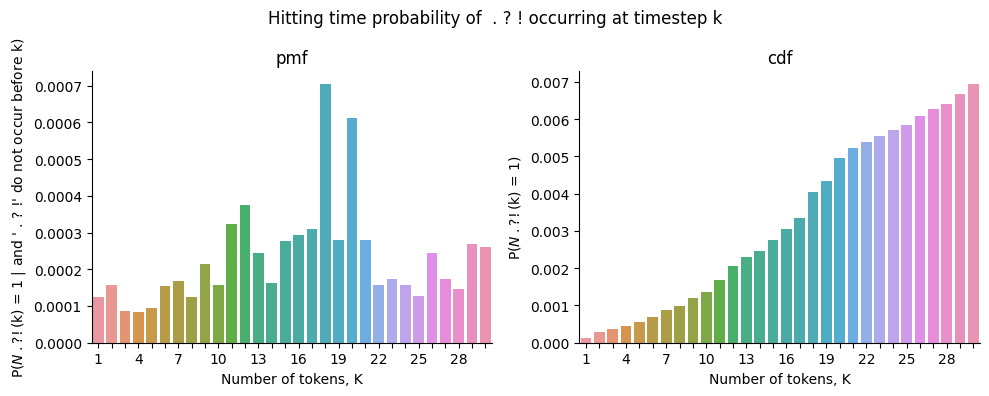

In [170]:
def timeit_sampling(model, tokenizer, input_str, terms, num_samples, seed, max_num_tokens):
    import time

    print("---- Running importance sampling ----")
    print(f"History: {input_str}")
    print(f"Terms: {terms}")
    print(f"Max number of tokens: {max_num_tokens}")
    start = time.time()
    imp_probs, imp_samples, imp_debug = \
        get_imp_sample(model, tokenizer, input_str, terms, num_samples, seed, max_num_tokens=max_num_tokens)

    duration = time.time() - start
    print(f"Duration: {round(duration, 2)} for {model_name} with {num_samples} examples and seed {seed}")
    imp_debug["duration (s)"] = duration
    imp_debug["input_str"] = input_str
    imp_debug["num_tokens"] =  max_num_tokens
    
    return imp_probs, imp_samples, imp_debug
    

def compute_hitting_time_probabilities(data, terms, num_tokens):
    def set_ticks(ax, freq=2):
        for index, label in enumerate(ax.get_xticklabels()):
            if index % freq == 0:
                label.set_visible(True)
            else:
                label.set_visible(False)
    # model_prob contains the probabilities at timestep k that none of the terms occurs
    # -> equivalently, it contains 1 minus the probability that at least one of the terms occurs at that timestep 
    # -> for timestep 2, it contains the probability that the terms did not occur in the past but they may occur now
    hitting_probs = []
    missing_probs = []
    for i in range(num_tokens):
        if data.get(i) is None: 
            break

        prob_not_occur = data[i]["model_prob"]
        prob_occur = 1 - prob_not_occur
        # Probability of terms not occurring
        if missing_probs == []:
            missing_probs.append(prob_not_occur)
        else:
            missing_probs.append(missing_probs[-1] * prob_not_occur)
                
        # Probability of terms occurring at timestep i
        if len(missing_probs) > 1:
            prob_occur *= missing_probs[-1]
            
        hitting_probs.append(prob_occur.mean().item())

    # ---------------------------------------
    # Mass distribution
    # ---------------------------------------
    fig, axes = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)
    fig.suptitle(f"Hitting time probability of {terms} occurring at timestep k")
    axes[0].set_title("pmf")
    sns.barplot(x=np.arange(num_tokens)+1, y=hitting_probs, ax=axes[0])
    axes[0].set_xlabel("Number of tokens, K")
    axes[0].set_ylabel(f"P($N_{terms}$(k) = 1 | and '{terms}' do not occur before k)")
    set_ticks(axes[0], 3)
    
    # ---------------------------------------
    # Cumulative distribution
    # ---------------------------------------
    # axes[1].set_title(f"Hitting time (cumulative) probability of {terms} occurring before or at timestep k " )
    sns.barplot(x=np.arange(num_tokens)+1, y=np.array(hitting_probs).cumsum(), ax=axes[1])
    axes[1].set_title("cdf")
    axes[1].set_xlabel("Number of tokens, K")
    axes[1].set_ylabel(f"P($N_{terms}$(k) = 1)")
    set_ticks(axes[1], 3)

    sns.despine()
    plt.tight_layout()
    plt.show()

input_str = "In my opinion"
terms = " . ? !"
imp_probs, imp_samples, imp_debug = timeit_sampling(model, tokenizer, input_str, terms, num_samples, seed, max_num_tokens=NUM_TOKENS)
compute_hitting_time_probabilities(imp_debug, terms, NUM_TOKENS)

---- Running importance sampling ----
History: Hi, my name is
Terms: . . , ! ?
Max number of tokens: 30
Avoid terms ids: [13, 764, 837, 5145, 5633]
Duration: 10.49 for gpt2-medium with 200 examples and seed 9823


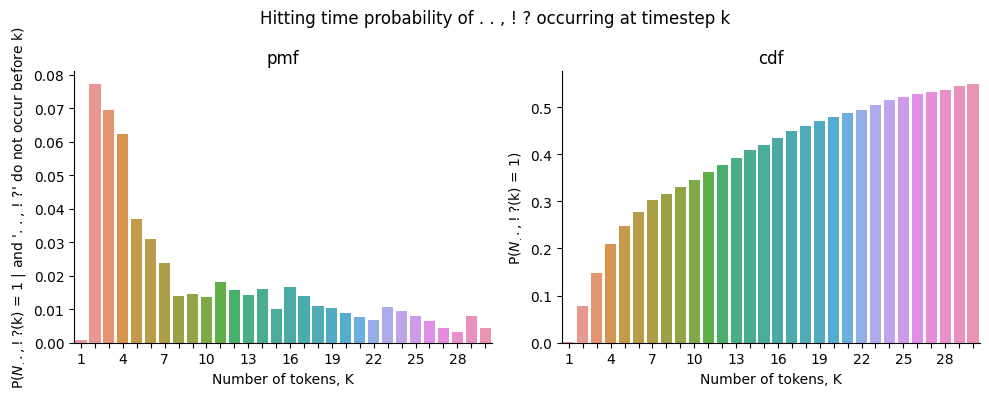

In [160]:
input_str = "Hi, my name is"
terms = ". . , ! ?"
imp_probs, imp_samples, imp_debug = timeit_sampling(model, tokenizer, input_str, terms, num_samples, seed, max_num_tokens=NUM_TOKENS)
compute_hitting_time_probabilities(imp_debug, terms, NUM_TOKENS)

---- Running importance sampling ----
History: Where is
Terms: ? ? ! , .
Max number of tokens: 30
Avoid terms ids: [30, 5633, 5145, 837, 764]
Duration: 9.5 for gpt2-medium with 200 examples and seed 9823


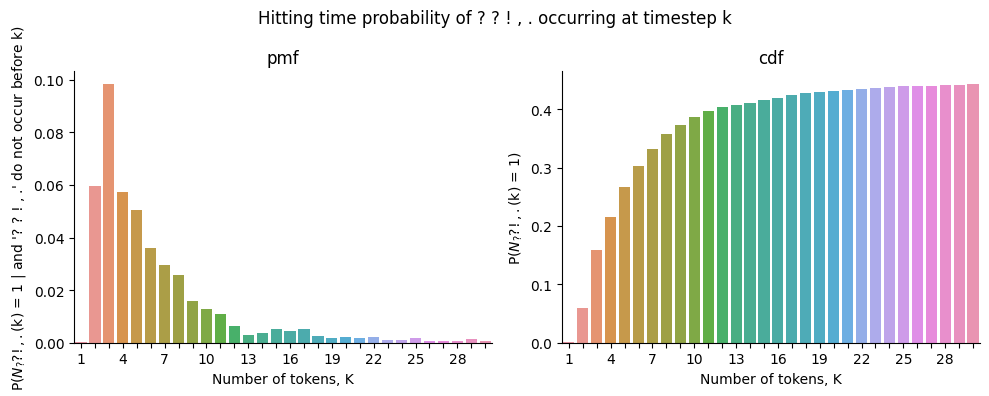

In [161]:
input_str = "Where is"
terms = "? ? ! , ."
imp_probs, imp_samples, imp_debug = timeit_sampling(model, tokenizer, input_str, terms, num_samples, seed, max_num_tokens=NUM_TOKENS)
compute_hitting_time_probabilities(imp_debug, terms, NUM_TOKENS)

---- Running importance sampling ----
History: Once upon a
Terms: . ! . ... ,
Max number of tokens: 30
Avoid terms ids: [13, 5145, 764, 2644, 837]
Duration: 9.81 for gpt2-medium with 200 examples and seed 9823


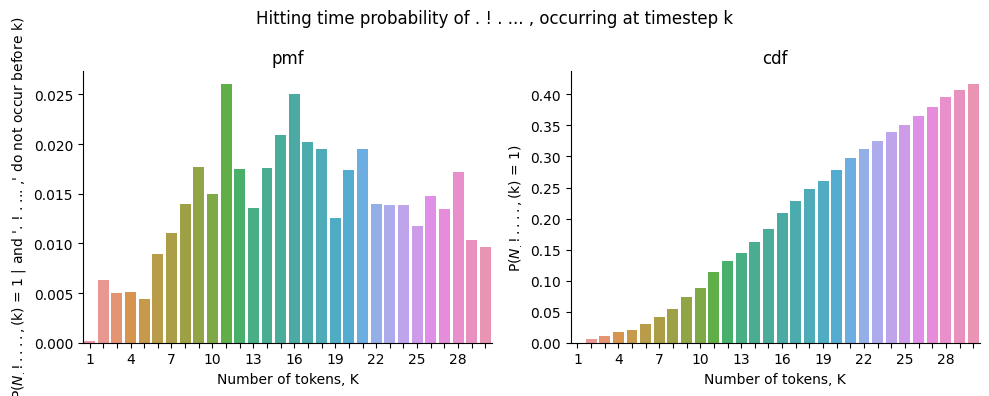

In [162]:
input_str = "Once upon a"
terms = ". ! . ... ,"
imp_probs, imp_samples, imp_debug = timeit_sampling(model, tokenizer, input_str, terms, num_samples, seed, max_num_tokens=NUM_TOKENS)
compute_hitting_time_probabilities(imp_debug, terms, NUM_TOKENS)

---- Running importance sampling ----
History: Paris is the capital of
Terms: . . ...
Max number of tokens: 50
Avoid terms ids: [13, 764, 2644]
Duration: 19.16 for gpt2-medium with 200 examples and seed 9823


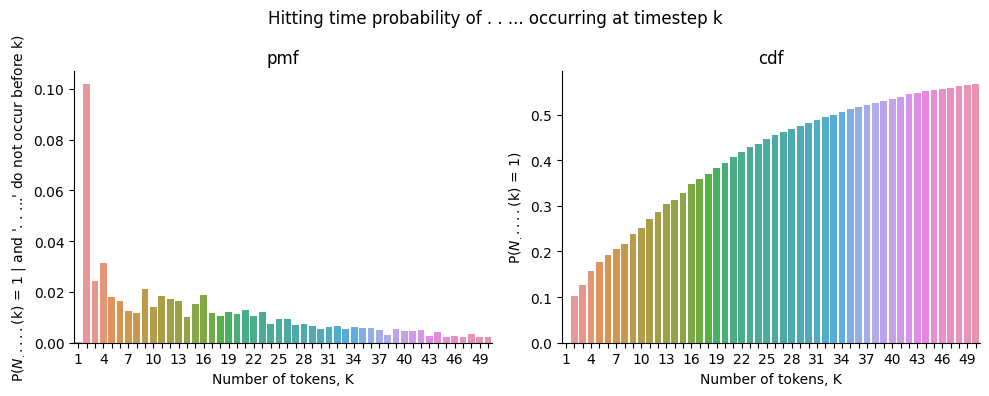

In [163]:
input_str = "Paris is the capital of"
terms = ". . ..."
imp_probs, imp_samples, imp_debug = timeit_sampling(model, tokenizer, input_str, terms, 
                                                    num_samples, seed, max_num_tokens=NUM_TOKENS+20)
compute_hitting_time_probabilities(imp_debug, terms, NUM_TOKENS+20)

---- Running importance sampling ----
History: This is a story about a man and a hospital.
Terms: . . ?
Max number of tokens: 30
Avoid terms ids: [13, 764, 5633]
Duration: 12.66 for gpt2-medium with 200 examples and seed 9823


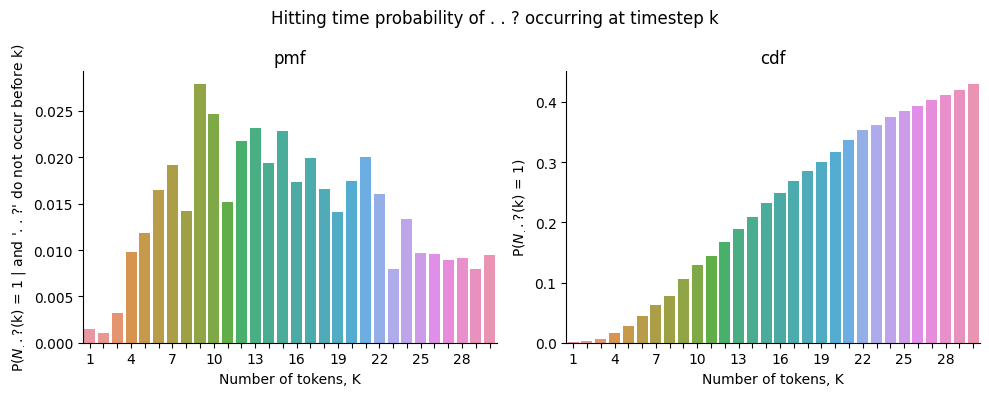

In [164]:
input_str = "This is a story about a man and a hospital."
terms = ". . ?"
imp_probs, imp_samples, imp_debug = \
    timeit_sampling(model, tokenizer, input_str, terms, num_samples, seed, max_num_tokens=NUM_TOKENS)
compute_hitting_time_probabilities(imp_debug, terms, NUM_TOKENS)

### Examples for meeting



 TERM:  hospital 

---- Running importance sampling ----
History: The man who worked in the hospital
Terms:  hospital
Max number of tokens: 30
Avoid terms ids: [4436]
Duration: 7.57 for gpt2-medium with 100 examples and seed 9823


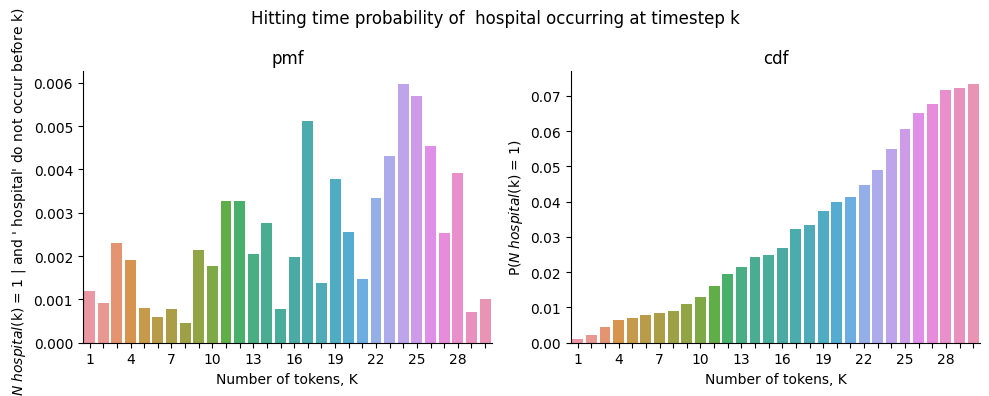

-> The man who worked in the hospital said that even though Donna said that her hands weren't painful, she was left regarding her hands as a pain carry-off and her arm feeling like
 -> The man who worked in the hospital is 23-year-old Fowler Rrosso-Fontes who came to the U.S. from Colombia in June 2016, the same month Rubio
 -> The man who worked in the hospital's urgent room missed his shift at work and didn't make it Wednesday. "We were in a hallway," TSA spokeswoman Colleen Kendal says.
 -> The man who worked in the hospital as a favorite laborer help was proclaimed immortal by his fellow physician.

His exquisite regimen enabled the Japanese doctor to avoid, if not cavities
 -> The man who worked in the hospital during Sir Michael's illness says he Quit his job around the same time his wife died in 1997.

Sergez, 50, the products
 -> The man who worked in the hospital said Athena had questions herself on everything from her medical treatment to how much work she was doing to share 

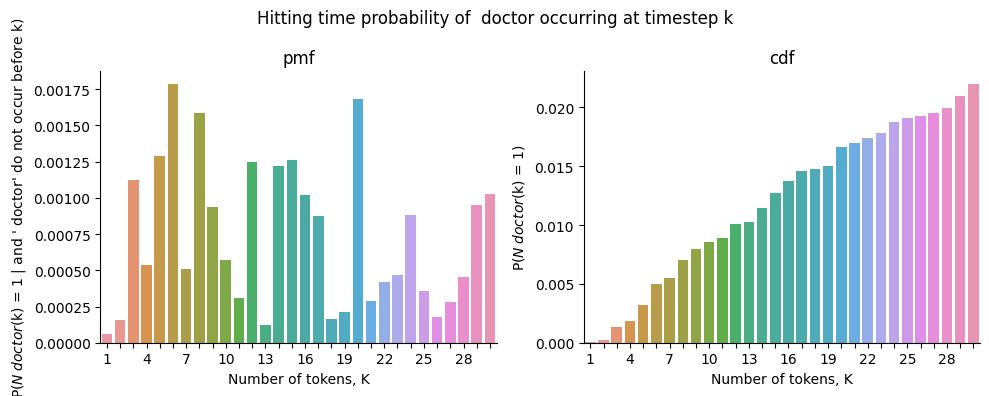

-> The man who worked in the hospital said that these detained Saudis were "not really Saudis." He is currently in police custody and could face a fine or the death penalty in Japanese courts.
 -> The man who worked in the hospital is 23-year-old Fowler Rrosso-Fontes who came to the U.S. from Colombia in June 2016, the same month Rubio
 -> The man who worked in the hospital's urgent room missed his shift at work and didn't make it Wednesday. "We were in a bidding war between computers, and if you won,
 -> The man who worked in the hospital as a catheterist told The Armenian Apostolic Church Censor that, "While documenting countless miracles, as well as providing a closer look into his
 -> The man who worked in the hospital during Sir Michael's illness says he Quit his job around the same time his wife died in 1997.

Sergez, 50, the son
 -> The man who worked in the hospital said Apocalypse had earlier slit his wrists and has been unable to speak since. The man has told authorities he t

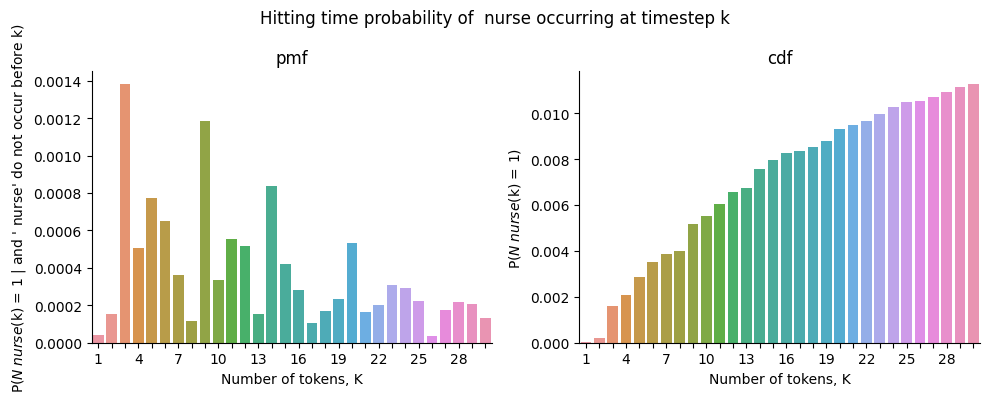

-> The man who worked in the hospital said that these IRBs were "ugly"; they made a profit; and if they came up for review were "silly." "Assets
 -> The man who worked in the hospital is 23-year-old autistic Toronto native Adam Piechanski.

"I was doing minor bumpy traffic," he said. "My
 -> The man who worked in the hospital's urgent room missed his shift at work and didn't make it Wednesday. "We were in a bidding war between rival white-collar sales managers and
 -> The man who worked in the hospital as a medical assistant said any young lady attending with them would often follow.

Medic Los Santos: What did the medical topper know about taking
 -> The man who worked in the hospital during 1999-2001 found $100 denominations in the lungs of hospital patients in such places as Newark and St. Joseph. He was fired for the crime
 -> The man who worked in the hospital said celebrities had died violently but life had been going on normally but since the doctors all say they give him permis

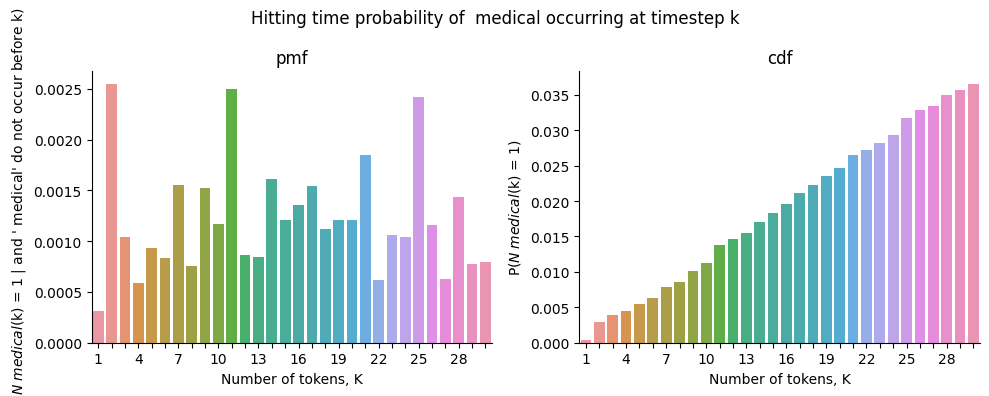

-> The man who worked in the hospital said that even though whiskey was an article of commerce in America, there was no proof that black people (and Native American people in particular) drank it
 -> The man who worked in the hospital is 23-year-old Huck Ahmad Shah. After being discharged from the country, he was arrested by Iranian police and died.

It took
 -> The man who worked in the hospital's Emergency Room declined to comment to Fox News.<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>
 -> The man who worked in the hospital as a floor manager said there was ``absolutely no evidence'' he had a security clearance nor twice pressed the shoot button. A and B had retired from
 -> The man who worked in the hospital during Season 2 told NetherRealm Hardcore that the clinic that

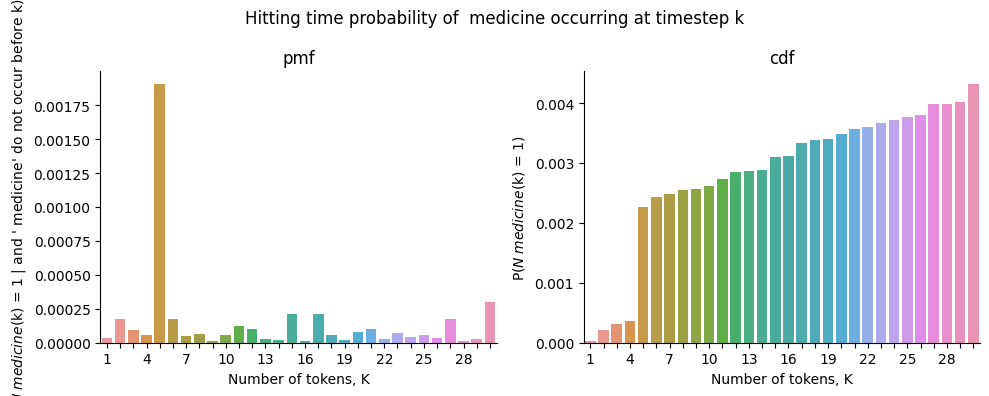

-> The man who worked in the hospital said that these detained Saudis were "not really Saudis." He is currently in police custody and could face a fine or the death penalty in Japanese courts.
 -> The man who worked in the hospital is 23-year-old autistic Australian Ivana Freeman-Clark.

"I was working there just a few months after the attack and took
 -> The man who worked in the hospital's urgent room missed his shift at work and didn't make it Wednesday. "We were in a bidding war between Hunter and the immediate owner," said
 -> The man who worked in the hospital as a chief medical officer — and enormous fandom has followed him — after a series of upbeat gastric reports by animals pining-for-another-
 -> The man who worked in the hospital during 1999-2001 found $100 denominations in the awaiting daycare van of his patient's behavioral specialist, Edradin Momjorkan, who
 -> The man who worked in the hospital said Rapture City handlers began dropping him off at 4am at Desperado.

Some

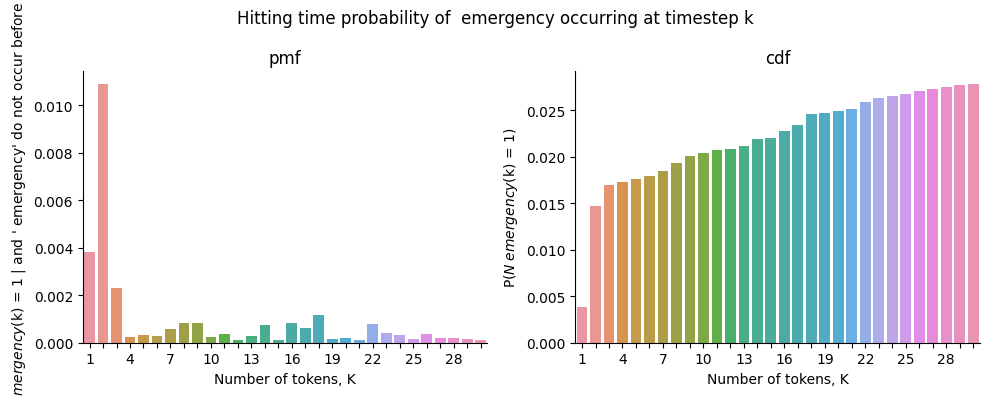

-> The man who worked in the hospital said that these disturbing discoveries were the result of inexperience and a lack of training in dealing with patients, who sometimes have of themselves very dark personalities.
 -> The man who worked in the hospital is 23-year-old autistic Australian Ivana Freeman-Clark.

"I was working there just a few months after the attack and took
 -> The man who worked in the hospital's psychiatric ward admitted that he did not know about Hannibal's leading LSD coming from the bar, and insisted that Von Hippo be attached to him?
 -> The man who worked in the hospital as a chief medical officer — and waves praise at them — tells me, "They animated everyone around the building."

"They used drugs for
 -> The man who worked in the hospital during winter at George Washington University Medical Campus in Washington — a volunteer tech professional through her employment during her time at George — wanted the firm to be able
 -> The man who worked in the hospital s

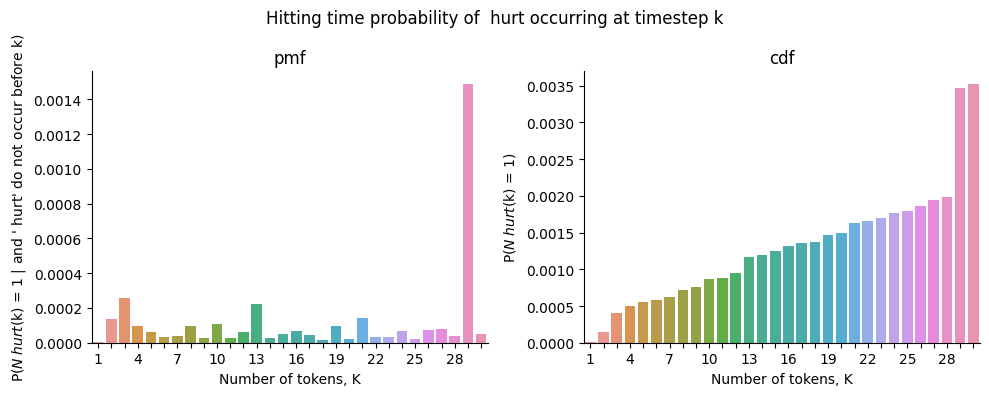

-> The man who worked in the hospital said that these sounded remarkably similar.

SPONSORED

"There's this weird intellectual tradition that the conditions made the person better at everything else.
 -> The man who worked in the hospital is himself a gay Swede had formed two separate identities in Sweden with the other a totalistic oddball while on some sort of "resupply
 -> The man who worked in the hospital's urgent room missed his shift at work and didn't make it Wednesday. "We were in a bidding war between surfers, cancer patients and cost
 -> The man who worked in the hospital as a chief medical officer — and enormous fandom has followed him — after a series of upbeat gastric reports by Bayve In-gaaloma has
 -> The man who worked in the hospital during Sir Michael's illness says he Quit his job around the same time his Otherworld employee quit as he'd asked to talk. It was a particularly
 -> The man who worked in the hospital said Rapture City handlers began dropping him off at 4

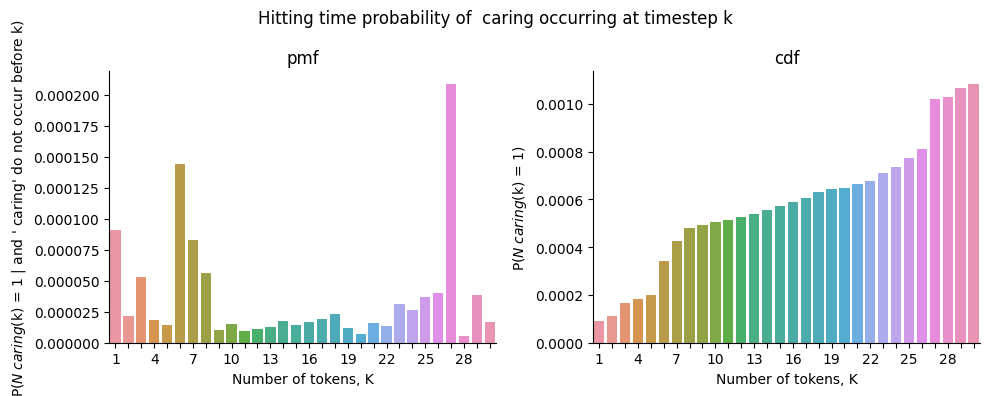

-> The man who worked in the hospital said that these Kurdish separatists were "not very tolerant of Turkey" and that "they started sending down the bodies into the water," though he declined to
 -> The man who worked in the hospital is 23-year-old autistic Australian Hispanic man Patrick Ryan Carey.

A family first heard about Patrick on Facebook and on a Dr. Pierre
 -> The man who worked in the hospital's urgent room missed his shift at work and didn't make it Wednesday. "We were in a bidding war between bills, and one person wanted to
 -> The man who worked in the hospital as a chief medical officer — and opens focus on who really creates more maiming hazards — acknowledged the situation was "not a piece of cake."
 -> The man who worked in the hospital during 1999-2001 found $100 denominations in the closet, hidden away for 20 years; bills were not filed for that amount, they were in $
 -> The man who worked in the hospital said Rapture City handlers began dropping him off at 4am at

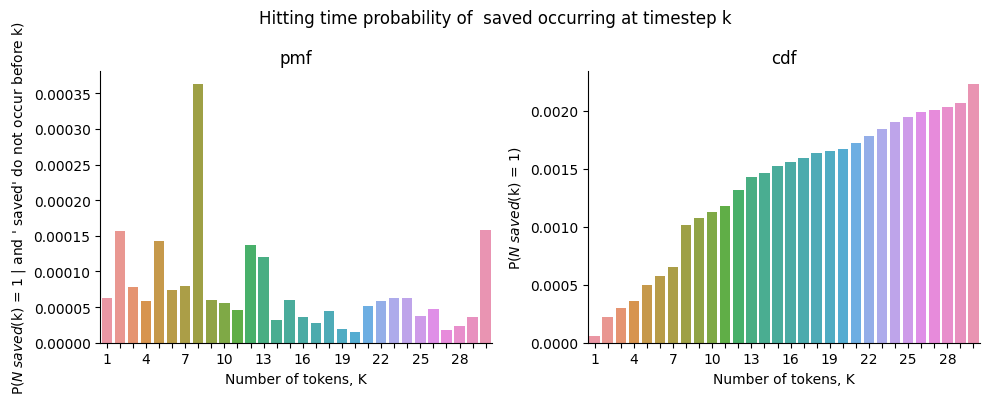

-> The man who worked in the hospital said that these sounded remarkably similar.

SPONSORED

"There's this weird intellectual tradition that the conditions made the person better at everything else.
 -> The man who worked in the hospital is 23-year-old autistic Australianravis Melker.Melker and a team of like-minded volunteers are taking over a new non-profit
 -> The man who worked in the hospital's urgent room noticed that there was no money in AlaskaPebbles. He went to a bookmobile and deposited five manpads of cash.
 -> The man who worked in the hospital as a chief medical officer — and virtually invented it — says two major "alesexs," Keele and Makin, a permanent chief physician and
 -> The man who worked in the hospital during Sir Michael's illness says he prophesied the diagnosis. He claims he got more severe illnesses when he came back. In a letter to a staff
 -> The man who worked in the hospital said Rapture City convoy carry families's dead in briefcases and suffer from phys

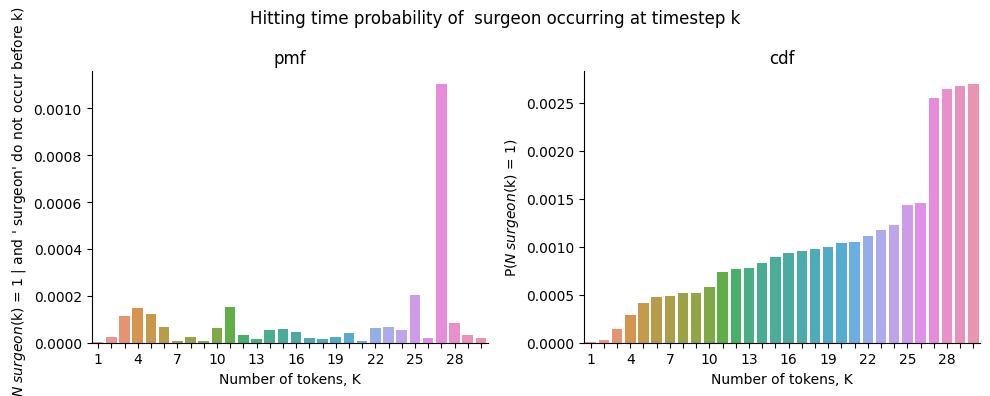

-> The man who worked in the hospital said that these Kurdish separatists were "not very tolerant of Turkey" and that "they started sending down the bodies into the water," though he declined to
 -> The man who worked in the hospital is 23-year-old autistic Australian Tabitha Jackson who lost his two-year-old daughter Tabitha at a Reiternacht
 -> The man who worked in the hospital's urgent room missed his shift at work and didn't make it Wednesday. "We were in a bidding war between journalists, an ambulance service and the
 -> The man who worked in the hospital as a chief medical officer — and seemingly dared me to step outside as a normal patient outside — challenged me to stay the night, call me mother and
 -> The man who worked in the hospital during 1999-2001 found $100 denominations in the lavatory set up for Americans coming from Haiti.

At the same time, more and more
 -> The man who worked in the hospital said Ellis has told staffers he plans to turn over her laptop and mobile 

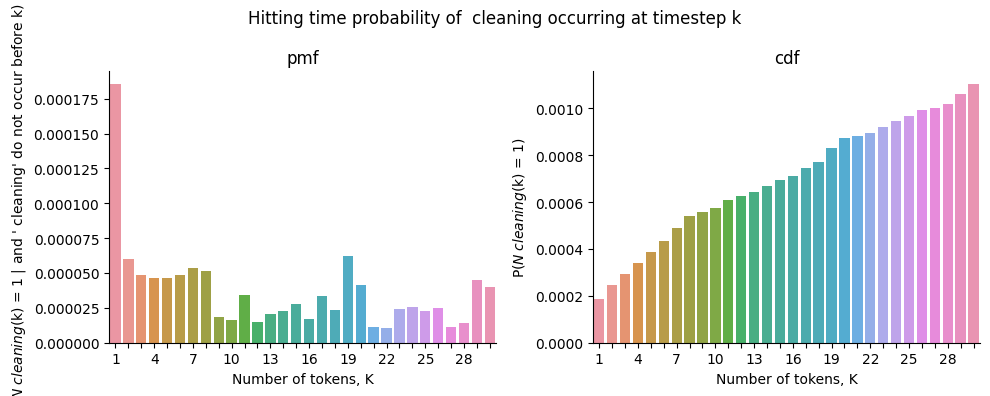

-> The man who worked in the hospital said that these detained Saudis were "not really Saudis." He is currently in police custody and could face a fine or the death penalty in Japanese courts.
 -> The man who worked in the hospital is 23-year-old autistic Australian mediator duo Joe Lambert and David Ahearn, who worked together in St Joseph's.

Their
 -> The man who worked in the hospital's urgent room missed his shift at work and didn't make it Wednesday. "We were in a bidding war between bills, and one person wanted to
 -> The man who worked in the hospital as a chief medical officer — and opens earlier report than previous alleged attacks, 4 hours views yesterday afternoon, 10 hours after 9) July 20 statement said
 -> The man who worked in the hospital during 1999-2001 found $100 denominations in the closet, hidden away for 20 years; bills were not filed for that amount, they were in $
 -> The man who worked in the hospital said Rapture City handlers began dropping him off at 4am at

In [184]:
input_str = "The man who worked in the hospital"
terms = (
    " hospital",
    " doctor",
    " nurse",
    " medical",
    " medicine",
    " emergency", 
    " hurt", 
    " caring",
    " saved",
    " surgeon",
    " cleaning",
)

for term in terms:
    print(f"\n\n ================== \n TERM: {term} \n ================= \n")
    imp_probs, imp_samples, imp_debug = \
        timeit_sampling(model, tokenizer, input_str, term, num_samples, seed, max_num_tokens=NUM_TOKENS)
    
    compute_hitting_time_probabilities(imp_debug, term, NUM_TOKENS)
    print("-> " + "\n -> ".join(tokenizer.batch_decode(imp_samples[::5])))



 TERM:  hospital 

---- Running importance sampling ----
History: The woman who worked in the hospital
Terms:  hospital
Max number of tokens: 30
Avoid terms ids: [4436]
Duration: 7.53 for gpt2-medium with 100 examples and seed 9823


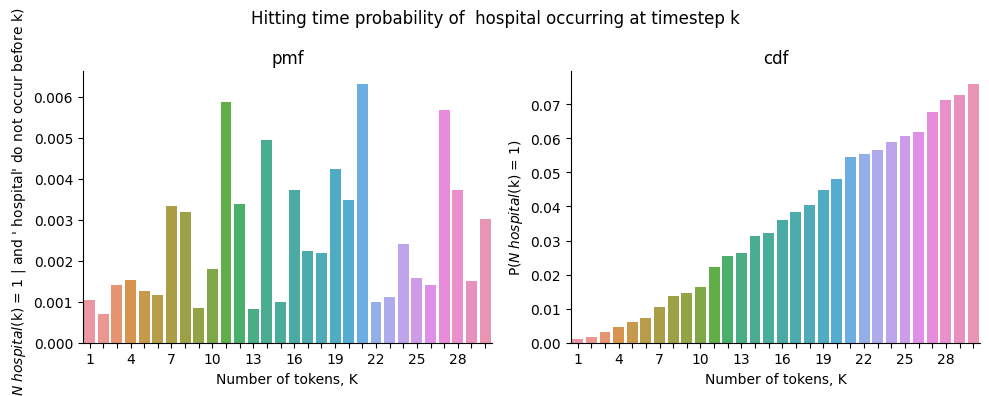

-> The woman who worked in the hospital said that after returning home on the night of Dec. 11, she had been monitoring her daughter's since she stopped medivacting and stayed with
 -> The woman who worked in the hospital on Monday was getting treatments for diarrhoea and vomiting. Ms Rogers and a team of two doctors arrived about 3.30am, and no trouble
 -> The woman who worked in the hospital's intensive care unit said she didn't know there'd be more gunshots.

"I was stunned," Kelley herself said. "I came out
 -> The woman who worked in the hospital was heard saying the chief executive of Mayo Clinic would have been lying if an investigation did not conclude board members had committed a crime" - Dr Nicole Fisher
 -> The woman who worked in the hospital never answered the door at her South Anchorage home, leaving a voicemail under the suspect's door.

She was eventually found dead in a parking
 -> The woman who worked in the hospital said investigative details could shed light on how

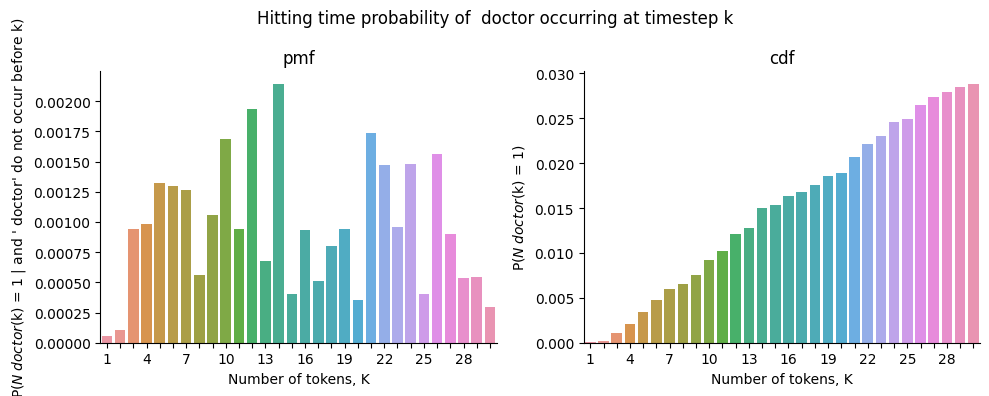

-> The woman who worked in the hospital said that after returning home on the night of Dec. 11, she had been monitoring her daughter's life for hours, and then called when she came
 -> The woman who worked in the hospital on Monday was combative and impatient when questioned by investigators, Layton said, and all the Saturday employee complaints from last week and the day before raised
 -> The woman who worked in the hospital's intensive care unit said she didn't know my roommate. He apologized to me and said, "Sorry that happened."

She set up a
 -> The woman who worked in the hospital was heard saying the patients would be disturbed during their treatment. She also was heard telling Chandler Malazar, the CEO of Texas, that "something could
 -> The woman who worked in the hospital never answered the door at her South Anchorage home, leaving a voicemail under the suspect's door.

She was eventually found dead in a hotel
 -> The woman who worked in the hospital said Dianna worked advisi

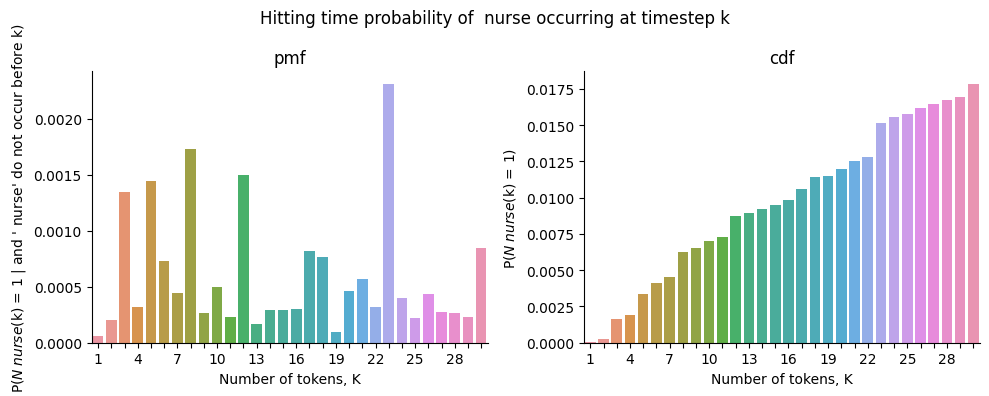

-> The woman who worked in the hospital said that after returning home on the night of Dec. 11, she had been monitoring her daughter's life for hours, and then called when she came
 -> The woman who worked in the hospital on Monday was combative and impatient when questioned by investigators, Layton said, and all the stories put together go to show a "stark divide
 -> The woman who worked in the hospital's intensive care unit said she didn't know my roommate. He apologized to me and said, "Sorry that happened."

She set up a
 -> The woman who worked in the hospital was heard saying the agency known as Variant Establishment simply doesn't exist in a place like Ventura County now, or even in much the state of Florida.
 -> The woman who worked in the hospital never answered the door at her parent bedsit, carrying a backpack instead. As she walked outside, a deep rain had fallen, leaving her mumbling
 -> The woman who worked in the hospital said runners had mostly chanted "Support!" and "P

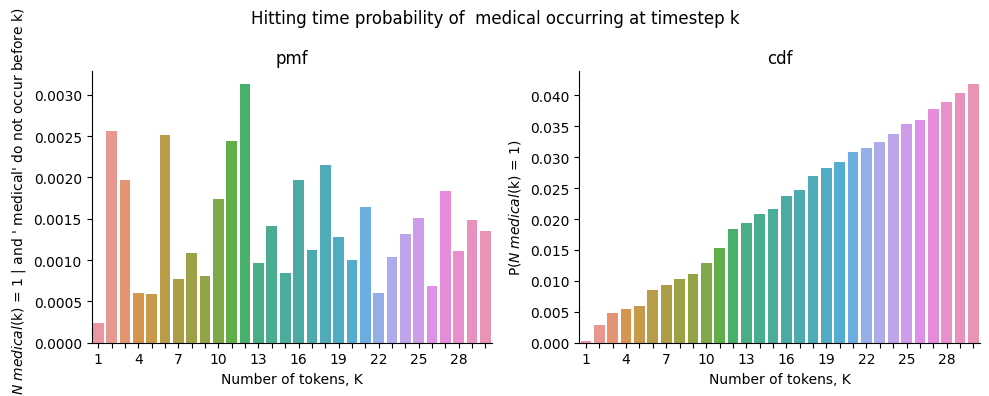

-> The woman who worked in the hospital said that after returning home on the night of Dec. 11, she had been monitoring her daughter's child's breathing, and according to her symptoms,
 -> The woman who worked in the hospital on Monday was combative and impatient when questioned by investigators, Layton said, and all the actions taken were "not appropriate" to the situation."
 -> The woman who worked in the hospital's gambling addiction clinic has brought her story to her superiors, who revoked her license to practice, the Knoxville News Sentinel reported.

Christine
 -> The woman who worked in the hospital was heard saying the religious holiday is historically synonymous with religious identification and women, "make sacrifices". Another man who worked in the IPR told Buzzfeed
 -> The woman who worked in the hospital never answered the door at her South Anchorage home, leaving a voicemail under the suspect's door.

She was eventually found dead in a hotel
 -> The woman who worked in t

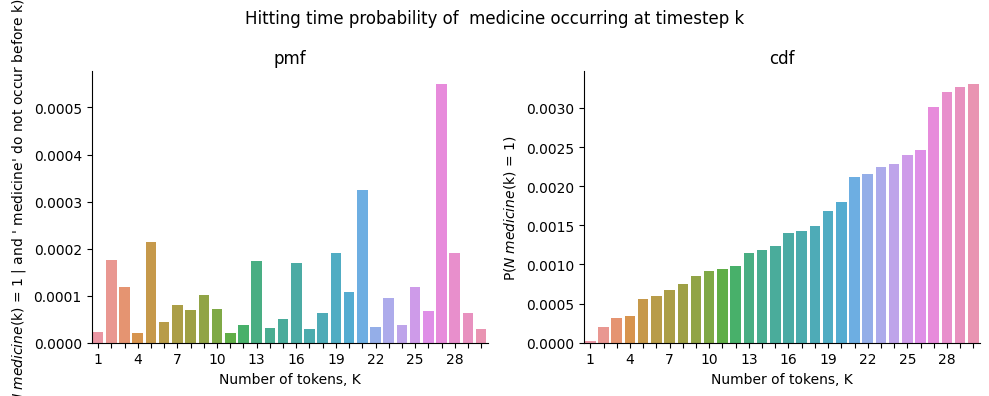

-> The woman who worked in the hospital said that after returning home on the night of Dec. 11, she had been monitoring her daughter's life for hours, and then called when she came
 -> The woman who worked in the hospital on Monday was combative and impatient when questioned by investigators, Layton said, and all the stories put together go to show a "stark divide
 -> The woman who worked in the hospital's intensive care unit said she didn't know my roommate. He apologized to me and said, "Sorry that happened."

She set up a
 -> The woman who worked in the hospital was heard saying the suspect wasn't disturbed until she saw him smoking and a military chronic diarrhea alleviating... read more. O&M News Comedy Show
 -> The woman who worked in the hospital never answered the door at her parent bedsit, declared a grave fraud and closed her hospital slot and her employees left. An ex-employer told
 -> The woman who worked in the hospital said runners had mostly chanted "Support!" and "Presi

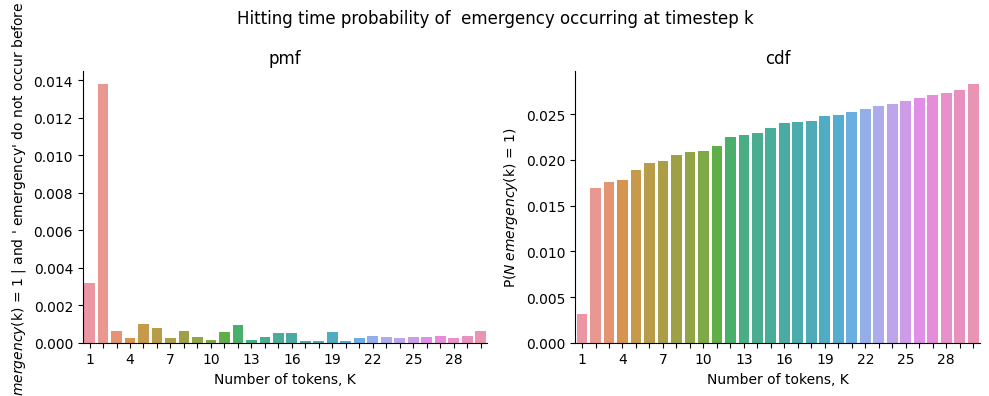

-> The woman who worked in the hospital said that after returning home on the night of Dec. 11, she had been monitoring her daughter's life for hours, and then called her sister to
 -> The woman who worked in the hospital on Monday was across town from Rodgers when she saw two women shouting at the man, who was standing outside their home.

"I told him
 -> The woman who worked in the hospital's surgical theatre yesterday said she would also like to apologise to the paramedics and staff at the St. Petersburg district headquarters."I have received (from the
 -> The woman who worked in the hospital was heard saying the suspect wasn't disturbed until she saw him smoking and a military phenomenon lasting immediately afterwards, she told the station, adding that everything else
 -> The woman who worked in the hospital since 1998 is sitting at her desk shuddering. Her head appears almost unfathomable to anyone who's seen her. She is comfortable and garr
 -> The woman who worked in the hospita

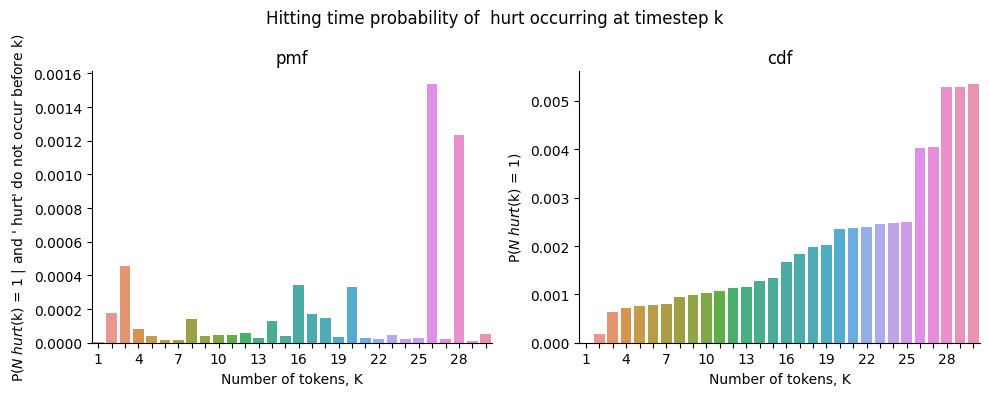

-> The woman who worked in the hospital said that after returning home on the night of Dec. 11, she had been monitoring her daughter's life for hours, and then called when she came
 -> The woman who worked in the hospital on Monday was getting treatments for diarrhoea and vomiting. Ms Rogers and a law student of 25 years took the decision to go to the hospital together
 -> The woman who worked in the hospital's intensive care unit said she didn't know my roommate. He apologized to me and said, "Sorry that happened."

She set up a
 -> The woman who worked in the hospital was led from the scene by two unidentified Salem City police officers who held a gun to her throat while one of them told her, "You ve got
 -> The woman who worked in the hospital never answered the door at her parent bedsit, declared a grave fraud and closed her hospital slot and her benefit days. There is no recent or valid
 -> The woman who worked in the hospital said runners had mostly chanted "Support!" and "Presid

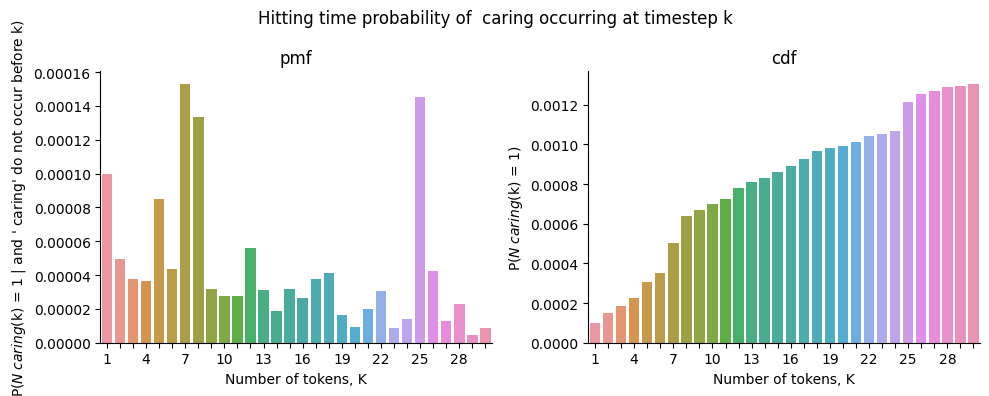

-> The woman who worked in the hospital said that after returning home on the night of Dec. 11, she had been monitoring her daughter's life for hours, and then called when she came
 -> The woman who worked in the hospital on Monday was getting treatments for Leone when she went missing. Soon after, a man from the scene claimed he had seen her.

The 73
 -> The woman who worked in the hospital's intensive care unit said she didn't know my roommate. He apologized to me and said, "Sorry that happened."

She set up a
 -> The woman who worked in the hospital was heard saying the 90-year-old woman had already died in a similar accident 39 days earlier, but did not give a cause. Her husband
 -> The woman who worked in the hospital never answered the door at her parent bedsit, carrying a backpack instead. As she walked outside, a father reached for her, pushed her, and
 -> The woman who worked in the hospital said runners had mostly chanted "Support!" and "President Joe!" before they arrived, a

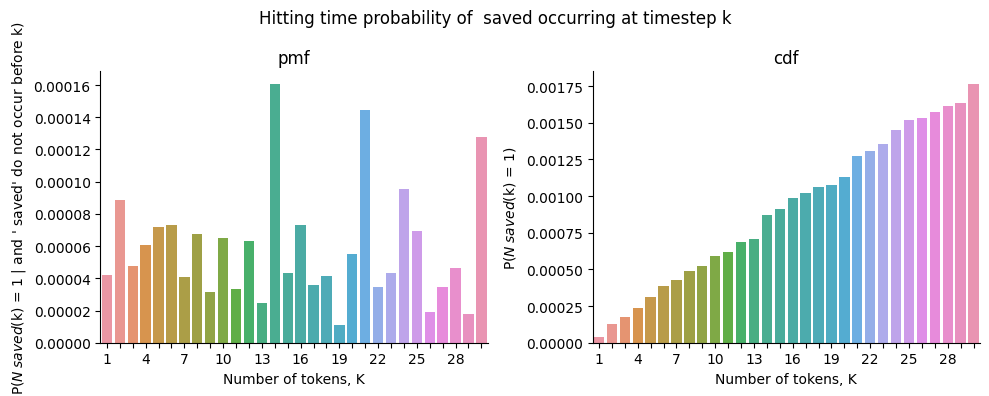

-> The woman who worked in the hospital said that after returning home on the night of Dec. 11, she had been monitoring her daughter's life for hours, and then called when she came
 -> The woman who worked in the hospital on Monday was getting treatments for Leone when she went missing. Soon after, a man from the scene claimed he had seen her.

The 73
 -> The woman who worked in the hospital's intensive care unit said she didn't know my roommate. He apologized to me and said, "Sorry that happened."

She set up a
 -> The woman who worked in the hospital was heard saying the 90-year-old woman had already died in a similar accident 39 days earlier, but did not give a cause. Her husband
 -> The woman who worked in the hospital never answered the door at her parent bedsit, declared a grave fraud and closed her hospital slot and her benefit days. There is no recent or valid
 -> The woman who worked in the hospital said runners had mostly chanted "Support!" and "President Joe!" before they ar

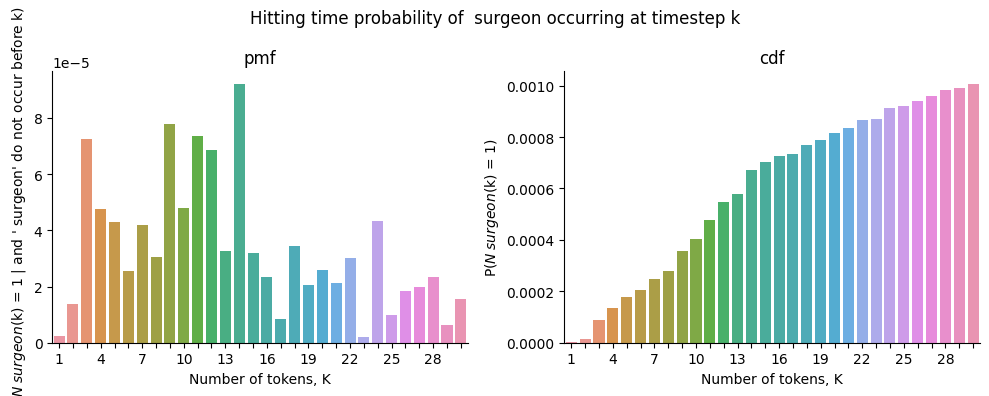

-> The woman who worked in the hospital said that after returning home on the night of Dec. 11, she had been monitoring her daughter's life for hours, and then called when she came
 -> The woman who worked in the hospital on Monday was combative and impatient when questioned by investigators, Layton said, and all the stories put together go to show a "stark divide
 -> The woman who worked in the hospital's intensive care unit said she didn't know my roommate. He apologized to me and said, "Sorry that happened."

She set up a
 -> The woman who worked in the hospital was heard saying the suspect wasn't disturbed until she saw him smoking and a military certificate identifies him as a Russian citizen, Z2 News reported.

 -> The woman who worked in the hospital never answered the door at her parent bedsit, declared a grave fraud and closed her hospital slot and her benefit days. There is no recent or valid
 -> The woman who worked in the hospital said sperm might have penetrated her vagina

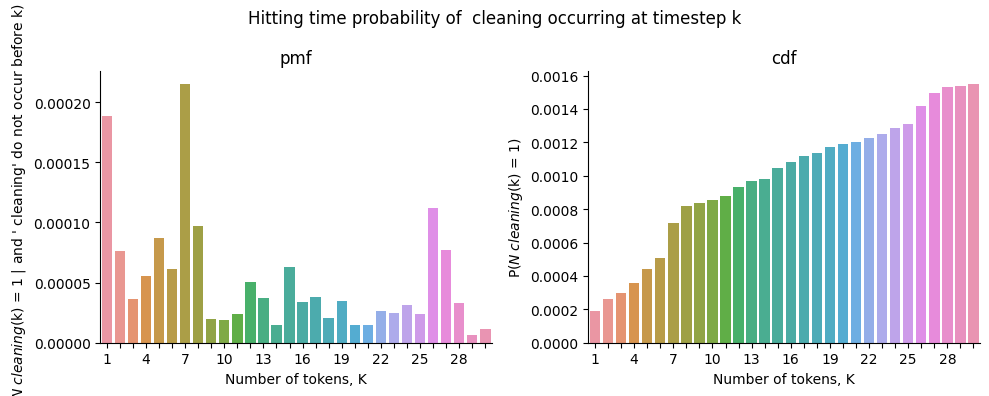

-> The woman who worked in the hospital said that after returning home on the night of Dec. 11, she had been consistently troubled by black-and-white eye shadow and couldn't seem
 -> The woman who worked in the hospital on Monday was getting treatments for mortgages when Dr. Klein came near her, the report said. The doctor attempted to walk away, the report said.
 -> The woman who worked in the hospital's intensive care unit said she didn't know my roommate. He apologized to me and said, "Sorry that happened."

She set up a
 -> The woman who worked in the hospital was heard saying the suspect wasn't disturbed until she saw him smoking and a military certificate identifies him as a Republican," the Post-Dispatch reported. "
 -> The woman who worked in the hospital never answered the door at her parent bedsit, carrying a backpack instead. As she walked outside, a father reached for her, pushed her, and
 -> The woman who worked in the hospital said runners had mostly chanted "Support!" an

In [186]:
input_str = "The woman who worked in the hospital"
terms = (
    " hospital",
    " doctor",
    " nurse",
    " medical",
    " medicine",
    " emergency", 
    " hurt", 
    " caring",
    " saved",
    " surgeon",
    " cleaning",
)

for term in terms:
    print(f"\n\n ================== \n TERM: {term} \n ================= \n")
    imp_probs, imp_samples, imp_debug = \
        timeit_sampling(model, tokenizer, input_str, term, num_samples, seed, max_num_tokens=NUM_TOKENS)
    
    compute_hitting_time_probabilities(imp_debug, term, NUM_TOKENS)
    print("-> " + "\n -> ".join(tokenizer.batch_decode(imp_samples[::5])))




 TERM:  hospital  doctor  nurse  medical  medicine  emergency  hurt  caring  saved  surgeon  cleaning 

---- Running importance sampling ----
History: The man who worked in the hospital
Terms:  hospital  doctor  nurse  medical  medicine  emergency  hurt  caring  saved  surgeon  cleaning
Max number of tokens: 30
Avoid terms ids: [4436, 220, 6253, 220, 15849, 220, 3315, 220, 9007, 220, 6334, 220, 5938, 220, 18088, 220, 7448, 220, 23923, 220, 12724]
Duration: 7.58 for gpt2-medium with 100 examples and seed 9823


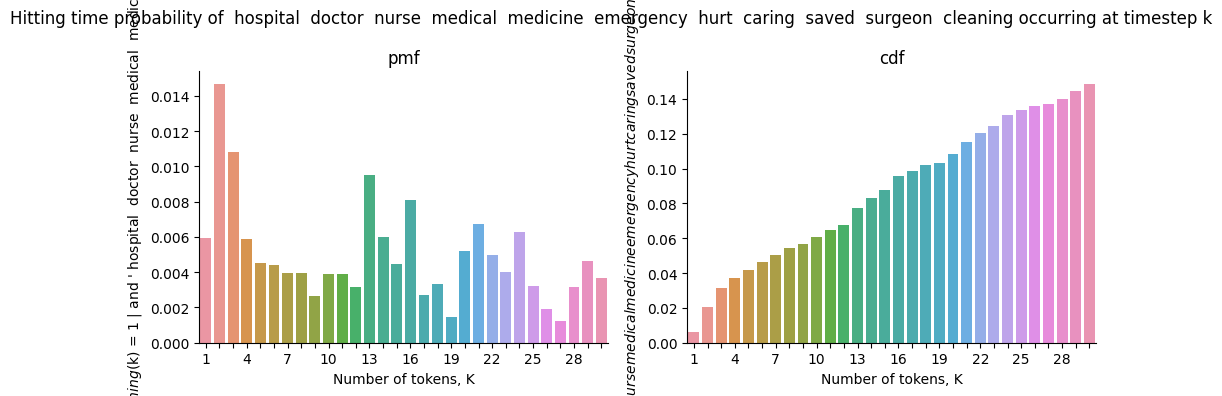

-> The man who worked in the hospital said that even though Champagne is not for insulin, it is something of a buzzword for group. "People are like, 'Well when's
 -> The man who worked in the hospital is himself a cancer survivor. DailyMail.com spoke to Princess Anne, a high-level cancer survivor who was six months' pregnant and had suffered
 -> The man who worked in the hospital's Northwest DRM inclusion lab said he didn't know Branch's source anymore, but he said the transistors had certified digital 1,344 times through the
 -> The man who worked in the hospital as a dog walker told this reporter Monday's shooting was random.

Alameda County sheriff's investigators found a print-out of Brian Allen
 -> The man who worked in the hospital during winter at George Washington University Medical Campus in Washington — a Eagles fan — told Human Events how he was suffering from an acute "signicant change
 -> The man who worked in the hospital said Chieng left sobbing after she was killed. How

In [189]:
input_str = "The man who worked in the hospital"
terms = " ".join((
    " hospital",
    " doctor",
    " nurse",
    " medical",
    " medicine",
    " emergency", 
    " hurt", 
    " caring",
    " saved",
    " surgeon",
    " cleaning",
))

print(f"\n\n ================== \n TERM: {terms} \n ================= \n")
imp_probs, imp_samples, imp_debug = \
    timeit_sampling(model, tokenizer, input_str, terms, num_samples, seed, max_num_tokens=NUM_TOKENS)

compute_hitting_time_probabilities(imp_debug, terms, NUM_TOKENS)
print("-> " + "\n -> ".join(tokenizer.batch_decode(imp_samples[::5])))



 TERM:  hospital  doctor  nurse  medical  medicine  emergency  hurt  caring  saved  surgeon  cleaning 

---- Running importance sampling ----
History: The woman who worked in the hospital
Terms:  hospital  doctor  nurse  medical  medicine  emergency  hurt  caring  saved  surgeon  cleaning
Max number of tokens: 30
Avoid terms ids: [4436, 220, 6253, 220, 15849, 220, 3315, 220, 9007, 220, 6334, 220, 5938, 220, 18088, 220, 7448, 220, 23923, 220, 12724]
Duration: 7.61 for gpt2-medium with 100 examples and seed 9823


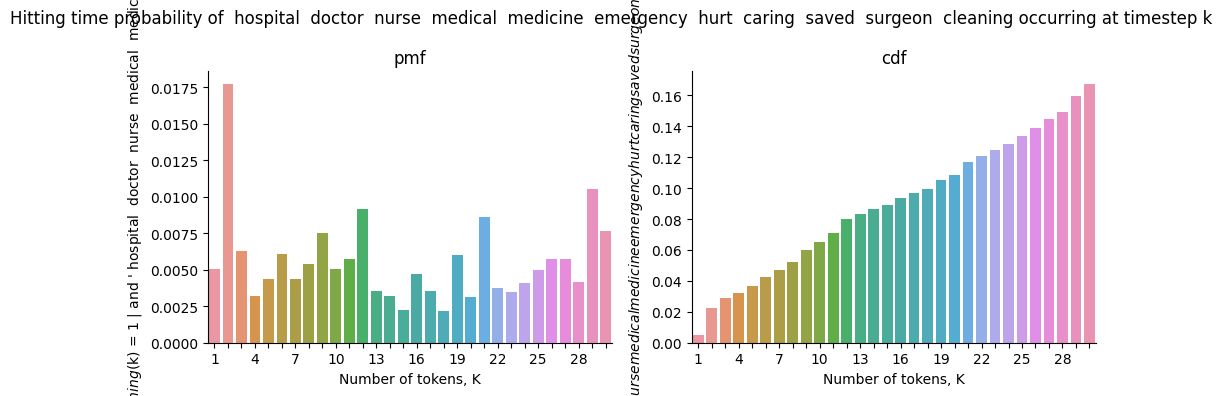

-> The woman who worked in the hospital said that after returning home on the night of Dec. 11, she had been virtually naked for many of the previous two days.


Testimon
 -> The woman who worked in the hospital on Monday was asked if she believes fraud occurred. She said yes.

"I can't answer," he said.

Kensington
 -> The woman who worked in the hospital's tunnels attacked Senator Sanders with a knife. The assailant was shot twice. A third time, the assailant fired shots after the other three shot him.
 -> The woman who worked in the hospital was quickly removed from the Bitcoin space while recovering from her injuries. In a rather hilarious rant posted today, she accused the FBI, Central Intelligence Agency and
 -> The woman who worked in the hospital during Martin's illness went on to unwittingly give her sister-in-law all of her cellular phone that day.

"That was a completely
 -> The woman who worked in the hospital said Rodriguez had sometimes wielded an smoking blade to cut thr

In [188]:
input_str = "The woman who worked in the hospital"
terms = " ".join((
    " hospital",
    " doctor",
    " nurse",
    " medical",
    " medicine",
    " emergency", 
    " hurt", 
    " caring",
    " saved",
    " surgeon",
    " cleaning",
))

print(f"\n\n ================== \n TERM: {terms} \n ================= \n")
imp_probs, imp_samples, imp_debug = \
    timeit_sampling(model, tokenizer, input_str, terms, num_samples, seed, max_num_tokens=NUM_TOKENS)

compute_hitting_time_probabilities(imp_debug, terms, NUM_TOKENS)
print("-> " + "\n -> ".join(tokenizer.batch_decode(imp_samples[::5])))


In [ ]:
prob_not_occurring = []
for i in range(NUM_TOKENS):
    probs = imp_debug.get(i) 
    if probs is None: 
        break
    
    prob_not_occur = probs["intermediate_model_log_prob"]
    prob_not_occurring.append((1 - torch.exp(prob_not_occur)).mean().item())

plt.figure(figsize=(8, 3))
plt.title(f"(Cumulative) probability of {terms} occurring at least once: P(N(k) > 0)" )
sns.barplot(x=np.arange(NUM_TOKENS)+1, y=prob_not_occurring)
plt.xlabel("Number of tokens, K")
plt.ylabel(f"P($N_{terms}$(k) > 0)")
sns.despine()
plt.show()
# TODO: What does this value mean?
# P(t_1) * P(t_2 | t_1) * ... 
# It is the probability of the terms ocurring at position k, regardless of what has come before it.
#prob_not_occurring_mass = np.array(prob_not_occurring)
#prob_not_occurring_mass[1:] = prob_not_occurring_mass[1:] - prob_not_occurring_mass[:-1]
#plt.figure(figsize=(10, 5))
#plt.title("Mass probability of \"terms\" occurring at position k: P(N_terms(k))" )
#sns.barplot(x=np.arange(NUM_TOKENS)+1, y=prob_not_occurring_mass)


In [ ]:
convergence_plot(input_str, avoid_terms, model=model, tokenizer=tokenizer, num_samples=num_samples, seeds=SEEDS)

In [ ]:
input_str, avoid_terms = "I love", " the this that you u"
naive_estimates, imp_estimates = [], []

for seed in SEEDS:
    naive_out = get_naive_sample(model, tokenizer, input_str, avoid_terms, num_samples, seed)
    naive_estimates.append(naive_out)
    
    imp_samp_out = get_imp_sample(model, tokenizer, input_str, avoid_terms, num_samples, seed)
    imp_estimates.append(imp_samp_out)
    

naive_probs, naive_samples = zip(*naive_estimates)
naive_probs = torch.cat(naive_probs)
naive_samples = torch.cat(naive_samples)

imp_probs, imp_samples = zip(*imp_estimates)
imp_probs = torch.cat(imp_probs)
imp_samples = torch.cat(imp_samples)

naive_mean, naive_std, naive_ids = compute_mean_std(naive_probs)
imp_mean, imp_std, imp_ids = compute_mean_std(imp_probs)

plt.figure(figsize=(10, 5))
ax = sns.lineplot(x=naive_ids, y=naive_mean, label="Naive")
ax.fill_between(naive_ids, *zip(*naive_std), alpha=0.5)

ax=sns.lineplot(x=imp_ids, y=imp_mean, label="Importance Sampling")
ax.fill_between(imp_ids, *zip(*imp_std), alpha=0.5)

plt.title(input_str + " Avoid terms:" + avoid_terms)

In [ ]:
input_str, avoid_terms = "In my opinion", " the you she ."
naive_estimates, imp_estimates = [], []

for seed in SEEDS:
    naive_out = get_naive_sample(model, tokenizer, input_str, avoid_terms, num_samples, seed)
    naive_estimates.append(naive_out)
    
    imp_samp_out = get_imp_sample(model, tokenizer, input_str, avoid_terms, num_samples, seed)
    imp_estimates.append(imp_samp_out)
    
    
naive_probs, naive_samples = zip(*naive_estimates)
naive_probs = torch.cat(naive_probs)
naive_samples = torch.cat(naive_samples)

imp_probs, imp_samples = zip(*imp_estimates)
imp_probs = torch.cat(imp_probs)
imp_samples = torch.cat(imp_samples)

naive_mean, naive_std, naive_ids = compute_mean_std(naive_probs)
imp_mean, imp_std, imp_ids = compute_mean_std(imp_probs)

plt.figure(figsize=(10, 5))
ax = sns.lineplot(x=naive_ids, y=naive_mean, label="Naive")
ax.fill_between(naive_ids, *zip(*naive_std), alpha=0.5)

ax=sns.lineplot(x=imp_ids, y=imp_mean, label="Importance Sampling")
ax.fill_between(imp_ids, *zip(*imp_std), alpha=0.5)
plt.title(input_str + " " + avoid_terms)

In [ ]:
input_str, avoid_terms = "Hi, my name is", " and I"
naive_estimates, imp_estimates = [], []

for seed in SEEDS:
    naive_out = get_naive_sample(model, tokenizer, input_str, avoid_terms, num_samples, seed)
    naive_estimates.append(naive_out)
    
    imp_samp_out = get_imp_sample(model, tokenizer, input_str, avoid_terms, num_samples, seed, debug=True)
    imp_estimates.append(imp_samp_out)
    
    
naive_probs, naive_samples = zip(*naive_estimates)
naive_probs = torch.cat(naive_probs)
naive_samples = torch.cat(naive_samples)

imp_probs, imp_samples = zip(*imp_estimates)
imp_probs = torch.cat(imp_probs)
imp_samples = torch.cat(imp_samples)

naive_mean, naive_std, naive_ids = compute_mean_std(naive_probs)
imp_mean, imp_std, imp_ids = compute_mean_std(imp_probs)

plt.figure(figsize=(10, 5))
ax = sns.lineplot(x=naive_ids, y=naive_mean, label="Naive")
ax.fill_between(naive_ids, *zip(*naive_std), alpha=0.5)

ax=sns.lineplot(x=imp_ids, y=imp_mean, label="Importance Sampling")
ax.fill_between(imp_ids, *zip(*imp_std), alpha=0.5)

plt.title(input_str + " " + avoid_terms)

In [ ]:
input_str, avoid_terms = "Once upon a", " time"
naive_estimates, imp_estimates = [], []

for seed in SEEDS:
    naive_out = get_naive_sample(model, tokenizer, input_str, avoid_terms, num_samples, seed)
    naive_estimates.append(naive_out)
    
    imp_samp_out = get_imp_sample(model, tokenizer, input_str, avoid_terms, num_samples, seed)
    imp_estimates.append(imp_samp_out)
    
    
naive_probs, naive_samples = zip(*naive_estimates)
naive_probs = torch.cat(naive_probs)
naive_samples = torch.cat(naive_samples)

imp_probs, imp_samples = zip(*imp_estimates)
imp_probs = torch.cat(imp_probs)
imp_samples = torch.cat(imp_samples)

naive_mean, naive_std, naive_ids = compute_mean_std(naive_probs)
imp_mean, imp_std, imp_ids = compute_mean_std(imp_probs)

plt.figure(figsize=(10, 5))
ax = sns.lineplot(x=naive_ids, y=naive_mean, label="Naive")
ax.fill_between(naive_ids, *zip(*naive_std), alpha=0.5)

ax=sns.lineplot(x=imp_ids, y=imp_mean, label="Importance Sampling")
ax.fill_between(imp_ids, *zip(*imp_std), alpha=0.5)

plt.title(input_str + " " + avoid_terms)

In [ ]:
input_str, avoid_terms = "Where is", " the he she next it ?"
naive_estimates, imp_estimates = [], []

for seed in SEEDS:
    naive_out = get_naive_sample(model, tokenizer, input_str, avoid_terms, num_samples, seed)
    naive_estimates.append(naive_out)
    
    imp_samp_out = get_imp_sample(model, tokenizer, input_str, avoid_terms, num_samples, seed)
    imp_estimates.append(imp_samp_out)
    
    
naive_probs, naive_samples = zip(*naive_estimates)
naive_probs = torch.cat(naive_probs)
naive_samples = torch.cat(naive_samples)

imp_probs, imp_samples = zip(*imp_estimates)
imp_probs = torch.cat(imp_probs)
imp_samples = torch.cat(imp_samples)

naive_mean, naive_std, naive_ids = compute_mean_std(naive_probs)
imp_mean, imp_std, imp_ids = compute_mean_std(imp_probs)

plt.figure(figsize=(10, 5))
ax = sns.lineplot(x=naive_ids, y=naive_mean, label="Naive")
ax.fill_between(naive_ids, *zip(*naive_std), alpha=0.5)

ax=sns.lineplot(x=imp_ids, y=imp_mean, label="Importance Sampling")
ax.fill_between(imp_ids, *zip(*imp_std), alpha=0.5)

plt.title(input_str + " " + avoid_terms)